importing Jupyter notebook from proj_env.ipynb
{'Serve Apple Salad to Person in Red': {('Go to Green Apple', 'Take Green Apple', 'Go to Red Apple', 'Take Red Apple', 'Go to Knife', 'Prepare Green Apple', 'Prepare Red Apple', 'Go to Mixing Bowl', 'Prepare Apple Salad', 'Place Apple Salad on Plate', 'Serve plate to Person in Red'), ('Go to Red Apple', 'Take Red Apple', 'Go to Green Apple', 'Take Green Apple', 'Go to Knife', 'Prepare Red Apple', 'Prepare Green Apple', 'Go to Mixing Bowl', 'Prepare Apple Salad', 'Place Apple Salad on Plate', 'Serve plate to Person in Red')}, 'Serve Cheese Platter to Person in White': {('Go to White Cheese', 'Take White Cheese', 'Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to Knife', 'Prepare White Cheese', 'Prepare Yellow Cheese', 'Go to Plate', 'Place White Cheese on Plate', 'Place Yellow Cheese on Plate', 'Serve plate to Person in White'), ('Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to White Cheese', 'Take White Cheese', 'Go to Knife', 'Prepare

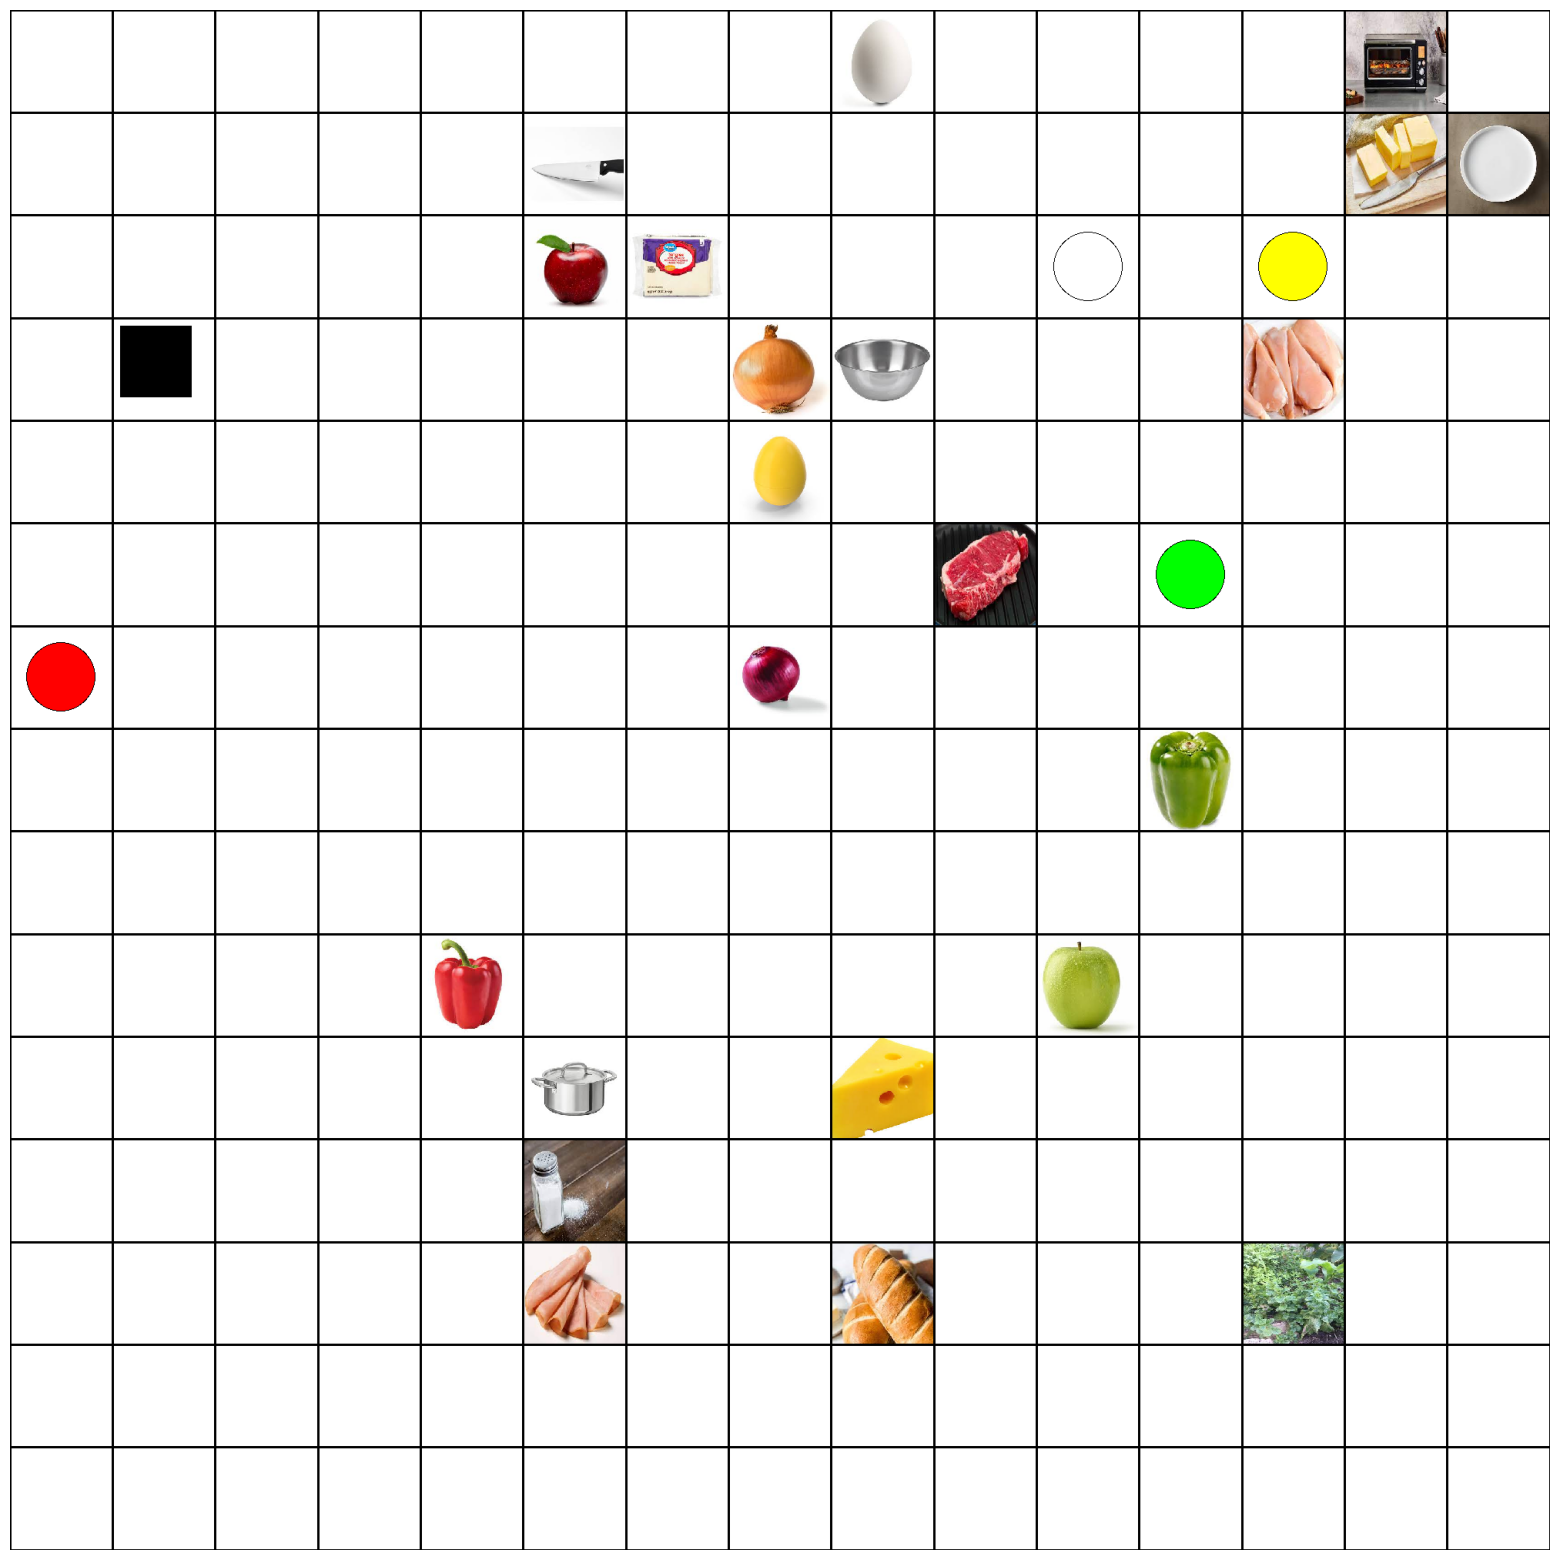

{'distance to Red Apple': 5.0, 'distance to Red Onions': 9.0, 'distance to Yellow Onions': 6.0, 'distance to Bread': 16.0, 'distance to Yellow Cheese': 14.0, 'distance to White Cheese': 6.0, 'distance to Red Bell Pepper': 9.0, 'distance to Green Bell Pepper': 14.0, 'distance to Green Apple': 15.0, 'distance to Yellow Egg': 7.0, 'distance to White Egg': 10.0, 'distance to Butter': 14.0, 'distance to Ham': 13.0, 'distance to Red Meat (Beef)': 10.0, 'distance to White Meat (Turkey)': 11.0, 'distance to Salt': 12.0, 'distance to Herbs': 20.0, 'distance to Pot': 11.0, 'distance to Oven': 15.0, 'distance to Knife': 6.0, 'distance to Mixing Bowl': 7.0, 'distance to Plate': 15.0, 'distance to Red Guest': 4.0, 'distance to White Guest': 10.0, 'distance to Green Guest': 12.0, 'distance to Yellow Guest': 12.0}
[]


[nltk_data] Downloading package punkt to /Users/lixiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
import gym
import random
import import_ipynb
import proj_env
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import json
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')

down = np.array([1,0])
up = np.array([-1,0])
right = np.array([0,1])
left = np.array([0,-1])

action_to_direction = {1: right,2: left,3: down,4: up}


food_list = ["RedApple", "RedOnions", "YellowOnions", "Bread", "YellowCheese", "WhiteCheese",
         "RedBellPepper", "GreenBellPepper", "GreenApple", "YellowEgg", "WhiteEgg", "Butter",
         "Ham", "RedMeat", "WhiteMeat", "Salt", "Herbs"]

tools_list =[ "Pot", "Oven", "Knife", "MixingBowl"]

guest_list = ["Red","White","Green","Yellow"]





    

In [2]:
def create_env(seed):
    random.seed(seed)

    the_n_env = proj_env.GridWorldEnv(render_mode='rgb_array')
    the_n_env.reset(seed = seed)
    return the_n_env


In [3]:
def show_env(env):
    image_array = env._render_frame()

    plt.figure(figsize=(20, 20))
    # Display the image array
    plt.imshow(image_array)
    plt.axis('off')  # Hide the axis
    plt.show()


In [4]:
def movingList(distance):
    
    x = distance[0]
    y = distance[1]
    lst = []
    a_lst = []
    if x < 0:
        for i in range(x,0):
            lst.append(1)
            a_lst.append("Right")
    elif x > 0:
        for i in range(x):
            lst.append(2)
            a_lst.append("Left")
    if y < 0:
        for i in range(y,0):
            lst.append(3)
            a_lst.append("Down")
    elif y > 0:
        for i in range(y):
            lst.append(4)
            a_lst.append("Up")

    return lst, a_lst

In [5]:
def get_vocab(f_name):
    info = dict()
    with open(f_name,"r") as f:
        d = json.load(f)
        for i in d["dataset"]:
            e = i["key"]
            if e not in info.keys():
                v = i["value"]
                n_v = set()
                for value in v:
                    n_v.add(tuple(value))
                info[e] = n_v
            else:
                value = info[e]
                v = i["value"]
                n_v = set()
                for elements in v:
                    n_v.add(tuple(elements))
                n_v = value.union(n_v)
                info[e] = n_v

    return info

#info key is command, value is set with multiple solutions and each solution type is tuple



In [6]:
def commandAnalysis(step):
    command = step.split(" ")[0]
    t = step.split(" ")[-1]
    target = ""
    target += t[0].upper()
    target += t[1:].lower()
    if target == "Onion":
        target = step.split(" ")[-2]+"Onions"
    elif target == "Apple" or target == "Egg" or target == "Meat" or target == "Cheese":
        target = step.split(" ")[-2]+target
    elif target == "Pepper":
        target = step.split(" ")[-3]+"Bell"+target
    elif target == "Bowl":
        target = "Mixing"+target
    elif target == "(turkey)":
        target = "WhiteMeat"
    elif target == "(beef)":
        target = "RedMeat"
    else:
        target = target
    
    return command, target



In [7]:
def get_action(env,info):
    optimal_action = dict()
    for key in info.keys():
        value = info[key]
        big_v = []
        for v in value:
            small_v = []
            loc = env._Agent_location
            last_reach = loc
            for step in v:
                command, target = commandAnalysis(step)
                if command == "Go":
                    other_loc = getattr(env, "_"+target + "_location")
                    distance=last_reach-other_loc
                    lst,a_lst = movingList(distance)
                    small_v += lst
                    last_reach = other_loc
                elif command == "Take":
                    small_v.append(5)
                
                elif command == "Prepare":
                    small_v.append(6)

                elif command == "Place":
                    other_loc = getattr(env, "_Plate_location")
                    distance=last_reach-other_loc
                    lst,a_lst = movingList(distance)
                    small_v += lst
                    last_reach = other_loc
                    small_v.append(6)

                elif command == "Serve":
                    other_loc = getattr(env, "_"+target + "_location")
                    distance=last_reach-other_loc
                    lst,a_lst = movingList(distance)
                    small_v += lst
                    last_reach = other_loc
                    small_v.append(7)
            big_v.append(small_v)
        optimal_action[key] = min(big_v, key=len)
    return optimal_action

def get_correct_dict(env,optimal_action):
    for i in optimal_action:
        env.step(i-1)
    return env.get_food_on()



In [8]:
info = get_vocab("699_recipe_data.json")
#env=create_env(0)
#optimal_action = get_action(env,info)
#optimal_act=optimal_action['Serve Apple Salad to Person in Red']
#print(get_correct_dict(env,optimal_act))

In [9]:
def make_words_tokenize(optimal_action):
    tokenized = [word_tokenize(text.lower()) for text in optimal_action.keys()]

    all_tokens = [token for text in tokenized  for token in text]
    vocab = Counter(all_tokens)

    word_to_index = {word: i + 1 for i, (word, _) in enumerate(vocab.items())}
    word_to_index["<unk>"] = len(word_to_index) + 1
    # print(word_to_index)

    tokenized_texts_indices = [[word_to_index[token] for token in text] for text in tokenized]

    # Define a maximum sequence length
    max_length = max(len(text) for text in tokenized_texts_indices)

    # Pad sequences with zeros
    padded_sequences = [text + [0] * (20 - len(text)) for text in tokenized_texts_indices]

    return padded_sequences, word_to_index, max_length




In [10]:
def get_test_tokeinize(test_action, my_dictionary):
    
    b_lst = []
    for text in test_action.keys():
        tokenized = word_tokenize(text.lower())
        lst = []
        for w in tokenized:
            if w in my_dictionary.keys():
                lst.append(my_dictionary[w])
            else:
                lst.append(my_dictionary["<unk>"])
        if len(lst)<20:
            lst += [0]*(20-len(lst))

        b_lst.append(lst)
    return b_lst

def make_action_tensor(optimal_action, word_to_index, max_length):
    opt_short_action = []
    for k in optimal_action.keys():
        v = optimal_action[k]

        opt_short_action.append(v)

    # print(opt_short_action)


    max_l =  150


    padded_act = [act + [0] * (max_l - len(act)) for act in opt_short_action]
    return padded_act,max_l


In [11]:
class BehaviorCloningModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes=8):
        super(BehaviorCloningModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_classes, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM

        out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)


        # Decode the hidden state of the last time step
        out = self.fc(out)  # out: tensor of shape (batch_size, seq_length, num_classes)

        return out



In [12]:
def training(batch_size,lr,epoch):
    model = BehaviorCloningModel2(1080, hidden_dim, 150)
    
    for i in range(10):
        random_number = random.randint(0, 20)
        env=create_env(random_number)
        optimal_action=get_action(env,info)
        padded_sequences, word_to_index, max_length = make_words_tokenize(optimal_action)
        padded_act,max_l = make_action_tensor(optimal_action, word_to_index, max_length)
        obs_lst = []
        matrix = [[0 for _ in range(15)] for _ in range(15)]
        for f in food_list:
            food_loc=getattr(env, "_"+f + "_location")
            new_matrix=matrix
            new_matrix[food_loc[0]][food_loc[1]]=1
            obs_lst.append(new_matrix)
        for t in tools_list:
            tool_loc=getattr(env, "_"+t + "_location")
            new_matrix=matrix
            new_matrix[tool_loc[0]][tool_loc[1]]=1
            obs_lst.append(new_matrix)
        for g in guest_list:
            guest_loc=getattr(env, "_"+g + "_location")
            new_matrix=matrix
            new_matrix[guest_loc[0]][guest_loc[1]]=1
            obs_lst.append(new_matrix)
        agent_loc=env._Agent_location
        new_matrix=matrix
        new_matrix[agent_loc[0]][agent_loc[1]]=1
        obs_lst.append(new_matrix)
        plate_loc=env._Plate_location
        new_matrix=matrix
        new_matrix[plate_loc[0]][plate_loc[1]]=1
        obs_lst.append(new_matrix)

        obs_lst_tensor=torch.tensor(obs_lst)
        pad_seq_tensor=torch.tensor(padded_sequences).unsqueeze(0)
        # Determine maximum size for each dimension
        max_size_0 = max(obs_lst_tensor.size(0), pad_seq_tensor.size(0))  # Max of the 1st dimension
        max_size_2 = max(obs_lst_tensor.size(2), pad_seq_tensor.size(2))  # Max of the 3rd dimension
        
        # Pad tensors to the same size
        obs_lst_tensor_padded = torch.nn.functional.pad(obs_lst_tensor, (0, max_size_2 - obs_lst_tensor.size(2), 0, 0, 0, max_size_0 - obs_lst_tensor.size(0)))
        pad_seq_tensor_padded = torch.nn.functional.pad(pad_seq_tensor, (0, max_size_2 - pad_seq_tensor.size(2), 0, 0, 0, max_size_0 - pad_seq_tensor.size(0)))
        obs_lst_tensor_padded = torch.nn.functional.pad(obs_lst_tensor_padded, (0, 0, 0, 13))  # Now shape is [27, 28, 20]
        # Concatenate along the second dimension
        concatenated_tensor = torch.cat((obs_lst_tensor_padded, pad_seq_tensor_padded), dim=1)  # Shape: [27, 56, 20]
        concatenated_tensor = concatenated_tensor.view(28, -1)
        dataset = TensorDataset(concatenated_tensor, torch.tensor(padded_act))
        
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        criterion = nn.HuberLoss()
        optimizer = optim.Adam(model.parameters(), lr)
        
        num_epochs = epoch  # Example value
    
        # model.train()
        pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")
        for epoch in pbar:
            for input_batch, target_batch in dataloader:  # Assuming dataloader is your data loader
                # Zero the parameter gradients
                optimizer.zero_grad()
                # Forward pass
                outputs = model(input_batch.float())
                loss = criterion(outputs.float(), target_batch.float())
    
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
            pbar.set_postfix(Loss=loss,The_epoch=epoch+1)
        return model,max_l

In [13]:
class BehaviorCloningModel2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_actions):
        super(BehaviorCloningModel2, self).__init__()
        
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_actions)



    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)


        return x

In [14]:
def get_correct_dict(env,optimal_action):

    for i in optimal_action:
        if (i-1)>=0 and (i-1)<=6:
            env.step(i-1)
        else:
            print(i-1)
            break
    return env.get_food_on()

def testing(f_name,seed,theModel,word_to_index,action_limited):
    success_c=0
    fail_c=0
    env=create_env(seed)
    info = get_vocab(f_name)
    optimal_action=get_action(env,info)
    padded_sequences, word_to_index, max_length = make_words_tokenize(optimal_action)
    padded_act,max_l = make_action_tensor(optimal_action, word_to_index, max_length)
    
    obs_lst = []
    matrix = [[0 for _ in range(15)] for _ in range(15)]
    for f in food_list:
        food_loc=getattr(env, "_"+f + "_location")
        new_matrix=matrix
        new_matrix[food_loc[0]][food_loc[1]]=1
        obs_lst.append(new_matrix)
    for t in tools_list:
        tool_loc=getattr(env, "_"+t + "_location")
        new_matrix=matrix
        new_matrix[tool_loc[0]][tool_loc[1]]=1
        obs_lst.append(new_matrix)
    for g in guest_list:
        guest_loc=getattr(env, "_"+g + "_location")
        new_matrix=matrix
        new_matrix[guest_loc[0]][guest_loc[1]]=1
        obs_lst.append(new_matrix)
    agent_loc=env._Agent_location
    new_matrix=matrix
    new_matrix[agent_loc[0]][agent_loc[1]]=1
    obs_lst.append(new_matrix)
    plate_loc=env._Plate_location
    new_matrix=matrix
    new_matrix[plate_loc[0]][plate_loc[1]]=1
    obs_lst.append(new_matrix)
    obs_lst_tensor=torch.tensor(obs_lst)
    pad_seq_tensor=torch.tensor(padded_sequences).unsqueeze(0)
    # Determine maximum size for each dimension
    max_size_0 = max(obs_lst_tensor.size(0), pad_seq_tensor.size(0))  # Max of the 1st dimension
    max_size_2 = max(obs_lst_tensor.size(2), pad_seq_tensor.size(2))  # Max of the 3rd dimension
    
    # Pad tensors to the same size
    obs_lst_tensor_padded = torch.nn.functional.pad(obs_lst_tensor, (0, max_size_2 - obs_lst_tensor.size(2), 0, 0, 0, max_size_0 - obs_lst_tensor.size(0)))
    pad_seq_tensor_padded = torch.nn.functional.pad(pad_seq_tensor, (0, max_size_2 - pad_seq_tensor.size(2), 0, 0, 0, max_size_0 - pad_seq_tensor.size(0)))
    obs_lst_tensor_padded = torch.nn.functional.pad(obs_lst_tensor_padded, (0, 0, 0, 13))  # Now shape is [27, 28, 20]
    # Concatenate along the second dimension
    concatenated_tensor = torch.cat((obs_lst_tensor_padded, pad_seq_tensor_padded), dim=1)  # Shape: [27, 56, 20]
    concatenated_tensor = concatenated_tensor.view(28, -1)
    dataset = TensorDataset(concatenated_tensor, torch.tensor(padded_act))
    batch_size = 1  # You can adjust this according to your needs

    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    for input_batch, target_batch in dataloader:
        result = theModel(input_batch.float())
        diff_total = 0
        action_sum = 0
        action_total = 0
        predict_command = []
        opt_command = []
        for i in range(len(target_batch[0])):
            if target_batch[0][i]!=0:
                diff = abs(result[0][i]-target_batch[0][i])
                diff_total += diff
                action_sum += target_batch[0][i]
                action_total += 1
                r = result[0][i]
                opt_command.append(int(target_batch[0][i]))
                if r>0 and r <8:
                    if int(r) == 0:
                        predict_command.append(1)
                    else:
                        a = abs(r-int(r))
                        if a>0.5:
                            predict_command.append(int(r)+1)
                        else:
                            predict_command.append(int(r))                 

            else:
                break
        print(diff_total/action_sum)
        print(diff_total/action_total)
        print(opt_command)
        print(predict_command)
        copy_env = create_env(seed)
        opt_bag = get_correct_dict(env,opt_command)
        pre_bag = get_correct_dict(copy_env,predict_command)
        if opt_bag==pre_bag:
            print("Success")
            success_c=success_c+1
        else:
            print("Fail")
            fail_c=fail_c+1
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(opt_bag)
        print(pre_bag)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("+++++++++++++++++++++++++++++")
        # print(result)
        # print(target_batch)
    print(f"Success count: {success_c}  Fail count: {fail_c}")

    


In [15]:
env=create_env(0)
optimal_action = get_action(env,info)
padded_sequences, word_to_index, max_length = make_words_tokenize(optimal_action)
padded_act,max_l = make_action_tensor(optimal_action, word_to_index, max_length)
obs_lst = []
for f in food_list:
    obs_lst.append(getattr(env, "_"+f + "_location"))
for t in tools_list:
    obs_lst.append(getattr(env, "_"+t + "_location"))
for g in guest_list:
    obs_lst.append(getattr(env, "_"+g + "_location"))
obs_lst.append(env._Agent_location)
obs_lst.append(env._Plate_location)
obs_lst_tensor=torch.tensor(obs_lst)
pad_seq_tensor=torch.tensor(padded_sequences)
max_seq_length = max(obs_lst_tensor.size(0), pad_seq_tensor.size(0))
obs_lst_tensor_padded = torch.nn.functional.pad(obs_lst_tensor, (0, 0, 0, max_seq_length - obs_lst_tensor.size(0)))
pad_seq_tensor_padded = torch.nn.functional.pad(pad_seq_tensor, (0, 0, 0, max_seq_length - pad_seq_tensor.size(0)))
obs_summary=obs_lst_tensor_padded

dataset = TensorDataset(obs_lst_tensor_padded, pad_seq_tensor_padded, torch.tensor(padded_act))
batch_size = 10  # You can adjust this according to your needs

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

vocab_size = len(word_to_index) + 1  # Assuming word_to_index is your vocabulary index
embedding_dim = 128  # Example value
hidden_dim = 256  # Example value
num_actions = 8  # Assuming 7 different actions + 1 for padding

/var/folders/y0/5n71953n2_76_0v3gh0g_rxr0000gn/T/ipykernel_92530/3710940589.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  obs_lst_tensor=torch.tensor(obs_lst)


In [ ]:
model,action_limited = training(10,0.001,50000)

Training:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 41913/50000 [03:43<00:43, 185.02epoch/s, Loss=tensor(0.0001, grad_fn=<HuberLossBackward0>), The_epoch=41922]

In [17]:
testing("699_recipe_test_1.json",0, model,word_to_index,action_limited=action_limited)
print("====================================")
testing("699_recipe_test_2.json",0, model,word_to_index,action_limited=action_limited)

AssertionError: Size mismatch between tensors

In [54]:
testing("699_recipe_data.json",3, model,word_to_index,action_limited=action_limited)

tensor(0.6647, grad_fn=<DivBackward0>)
tensor(1.7392, grad_fn=<DivBackward0>)
[1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 5, 1, 1, 1, 1, 3, 3, 3, 5, 2, 2, 2, 2, 3, 6, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 7]
[1, 1, 3, 3, 3, 5, 1, 1, 4, 4, 4, 4, 4, 4, 4, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 6, 1, 1, 1, 1, 1, 1, 1, 1]
Fail
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'RedApple': ['Knife', 'MixingBowl', 'Plate'], 'RedOnions': [], 'YellowOnions': [], 'Bread': [], 'YellowCheese': [], 'WhiteCheese': [], 'RedBellPepper': [], 'GreenBellPepper': [], 'GreenApple': ['Knife', 'MixingBowl', 'Plate'], 'YellowEgg': [], 'WhiteEgg': [], 'Butter': [], 'Ham': [], 'RedMeat': [], 'WhiteMeat': [], 'Salt': [], 'Herbs': []}
{'RedApple': [], 'RedOnions': [], 'YellowOnions': [], 'Bread': [], 'YellowCheese': [], 'Wh